In [1]:
import torch
import numpy as np
import scanpy as sc
import pickle
from sklearn.preprocessing import StandardScaler
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.sparse as sp

In [2]:
# Create necessary directories
os.makedirs('./models/dann/', exist_ok=True)

# 1. Data Loading and Preparation
print("Loading and preparing data...")
with open('./src/data/dann/all_cell_data.pkl', 'rb') as f:
    adata = pickle.load(f)

Loading and preparing data...


In [3]:
# Extract gene expression data and domain labels
X = adata.X  # Gene expression matrix

# Convert sparse matrix to dense
if sp.issparse(X):
    X = X.toarray()

# Extract domain labels
domain_labels = adata.obs['tech'].astype('category').cat.codes
domain_tensor = torch.tensor(domain_labels.values, dtype=torch.long)

# Extract cell type labels
adata.obs['cell_ontology_class'] = adata.obs['cell_ontology_class'].astype('category')
cell_labels = adata.obs['cell_ontology_class'].cat.codes
cell_tensor = torch.tensor(cell_labels.values, dtype=torch.long)

# Save for decoding later (optional)
cell_label_decoder = dict(enumerate(adata.obs['cell_ontology_class'].cat.categories))

# Standardize gene expression data
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)
X_tensor = torch.tensor(X_scaled, dtype=torch.float32)

# Total number of cells
num_cell_classes = len(torch.unique(cell_tensor))

# 📌 Now split X, domain labels, and cell labels together
X_train, X_val, domain_train, domain_val, cell_train, cell_val = train_test_split(
    X_tensor, domain_tensor, cell_tensor,
    test_size=0.2, random_state=42, stratify=domain_tensor  # or stratify=cell_tensor
)

In [4]:
class GradientReversalLayer(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

In [5]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 128)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.relu(self.fc2(x))

In [6]:
class DomainClassifier(nn.Module):
    def __init__(self, input_dim):
        super(DomainClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 2)  # Binary classification: Sampling Technique 1 vs 2

    def forward(self, x, alpha=1.0):
        x = GradientReversalLayer.apply(x, alpha)
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=1)

In [7]:
class CellClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(CellClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        return F.log_softmax(self.fc2(x), dim=1)


In [8]:
from torch.utils.data import Dataset

class SingleCellDataset(Dataset):
    def __init__(self, X, domain_labels, cell_labels):
        self.X = X
        self.domain_labels = domain_labels
        self.cell_labels = cell_labels

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.domain_labels[idx], self.cell_labels[idx]


In [9]:
# Hyperparameters
input_dim = X_tensor.shape[1]
hidden_dim = 512
lambda_domain = 1.0
num_epochs = 100
batch_size = 64
learning_rate = 1e-4

# Initialize models
encoder = Encoder(input_dim, hidden_dim)
domain_classifier = DomainClassifier(128)
cell_classifier = CellClassifier(128, num_cell_classes)

# Optimizer
optimizer = torch.optim.Adam(
    list(encoder.parameters()) +
    list(domain_classifier.parameters()) +
    list(cell_classifier.parameters()),
    lr=learning_rate
)

# Learning rate scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

In [10]:
# Create datasets and dataloaders
from torch.utils.data import DataLoader
train_dataset = SingleCellDataset(X_train, domain_train, cell_train)
val_dataset = SingleCellDataset(X_val, domain_val, cell_val)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=4, pin_memory=True)

/oscar/scratch/jfinberg/universalgene/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

encoder.to(device)
domain_classifier.to(device)
cell_classifier.to(device)

print(f"Using device: {device}")
print(f"Encoder parameters: {encoder.parameters()}")
print(f"Domain classifier parameters: {domain_classifier.parameters()}")
print(f"Cell classifier parameters: {cell_classifier.parameters()}")

Using device: cuda
Encoder parameters: <generator object Module.parameters at 0x7f66baf152a0>
Domain classifier parameters: <generator object Module.parameters at 0x7f66baf152a0>
Cell classifier parameters: <generator object Module.parameters at 0x7f66baf152a0>


In [12]:
import torch.nn.functional as F

def train_epoch(encoder, domain_classifier, cell_classifier, train_loader, optimizer, lambda_domain, epoch, num_epochs):
    encoder.train()
    domain_classifier.train()
    cell_classifier.train()
    
    total_loss = 0
    total_cell_acc = 0
    total_domain_acc = 0

    for batch_X, batch_domain, batch_cell in train_loader:
        batch_X = batch_X.to(device)
        batch_domain = batch_domain.to(device)
        batch_cell = batch_cell.to(device)
        
        # Forward pass
        alpha = 2. / (1. + np.exp(-10 * epoch / num_epochs)) - 1
        encoded = encoder(batch_X)
        
        domain_preds = domain_classifier(encoded, alpha=alpha)
        cell_preds = cell_classifier(encoded)
        
        # Losses
        domain_loss = F.nll_loss(domain_preds, batch_domain)
        cell_loss = F.nll_loss(cell_preds, batch_cell)
        loss = cell_loss + lambda_domain * domain_loss
        
        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        total_cell_acc += (cell_preds.argmax(1) == batch_cell).float().mean().item()
        total_domain_acc += (domain_preds.argmax(1) == batch_domain).float().mean().item()
    
    avg_loss = total_loss / len(train_loader)
    avg_cell_acc = total_cell_acc / len(train_loader)
    avg_domain_acc = total_domain_acc / len(train_loader)

    return avg_loss, avg_cell_acc, avg_domain_acc

def validate(encoder, domain_classifier, cell_classifier, val_loader, lambda_domain):
    encoder.eval()
    domain_classifier.eval()
    cell_classifier.eval()
    
    total_loss = 0
    total_cell_acc = 0
    total_domain_acc = 0

    with torch.no_grad():
        for batch_X, batch_domain, batch_cell in val_loader:
            batch_X = batch_X.to(device)
            batch_domain = batch_domain.to(device)
            batch_cell = batch_cell.to(device)
            
            encoded = encoder(batch_X)
            domain_preds = domain_classifier(encoded, alpha=1.0)  # Full strength at validation
            cell_preds = cell_classifier(encoded)

            domain_loss = F.nll_loss(domain_preds, batch_domain)
            cell_loss = F.nll_loss(cell_preds, batch_cell)
            loss = cell_loss + lambda_domain * domain_loss

            total_loss += loss.item()
            total_cell_acc += (cell_preds.argmax(1) == batch_cell).float().mean().item()
            total_domain_acc += (domain_preds.argmax(1) == batch_domain).float().mean().item()
    
    avg_loss = total_loss / len(val_loader)
    avg_cell_acc = total_cell_acc / len(val_loader)
    avg_domain_acc = total_domain_acc / len(val_loader)

    return avg_loss, avg_cell_acc, avg_domain_acc



Starting training...
Epoch 1/100
  Train Loss: 1.0672, Cell Acc: 0.7901, Domain Acc: 0.8930
  Val   Loss: 0.6290, Cell Acc: 0.8481, Domain Acc: 0.9542
--------------------------------------------------
Epoch 2/100
  Train Loss: 0.7332, Cell Acc: 0.8654, Domain Acc: 0.8767
  Val   Loss: 0.7329, Cell Acc: 0.8659, Domain Acc: 0.8759
--------------------------------------------------
Epoch 3/100
  Train Loss: 0.7248, Cell Acc: 0.8834, Domain Acc: 0.8461
  Val   Loss: 0.8140, Cell Acc: 0.8697, Domain Acc: 0.8224
--------------------------------------------------
Epoch 4/100
  Train Loss: 0.7881, Cell Acc: 0.8939, Domain Acc: 0.7923
  Val   Loss: 0.8472, Cell Acc: 0.8778, Domain Acc: 0.7968
--------------------------------------------------
Epoch 5/100
  Train Loss: 0.8323, Cell Acc: 0.9019, Domain Acc: 0.7512
  Val   Loss: 0.9523, Cell Acc: 0.8737, Domain Acc: 0.7514
--------------------------------------------------
Epoch 6/100
  Train Loss: 0.8514, Cell Acc: 0.9083, Domain Acc: 0.7179
  V

FileNotFoundError: [Errno 2] No such file or directory: './src/models/dann/training_curves.png'

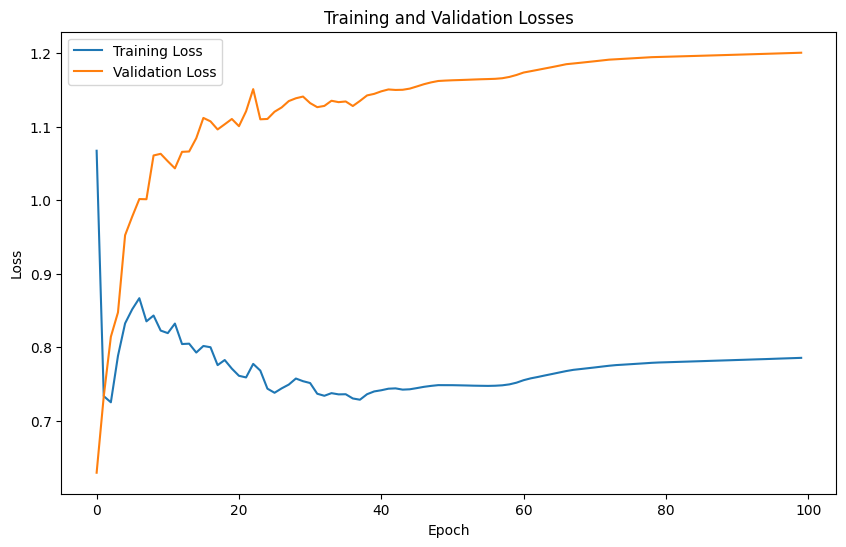

In [13]:
print("Starting training...")
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    train_loss, train_cell_acc, train_domain_acc = train_epoch(
        encoder, domain_classifier, cell_classifier,
        train_loader, optimizer, lambda_domain, epoch, num_epochs
    )

    val_loss, val_cell_acc, val_domain_acc = validate(
        encoder, domain_classifier, cell_classifier,
        val_loader, lambda_domain
    )

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"  Train Loss: {train_loss:.4f}, Cell Acc: {train_cell_acc:.4f}, Domain Acc: {train_domain_acc:.4f}")
    print(f"  Val   Loss: {val_loss:.4f}, Cell Acc: {val_cell_acc:.4f}, Domain Acc: {val_domain_acc:.4f}")
    print('-' * 50)

In [16]:
# 5. Visualization and Analysis
print("Generating visualizations...")

os.makedirs('./src/models/dann/', exist_ok=True)

# Plot training curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.savefig('./src/models/dann/training_curves.png')
plt.close()

# Move model to GPU
encoder = encoder.to(device)
X_tensor = X_tensor.to(device)

# Get embeddings
encoder.eval()
with torch.no_grad():
    embeddings = encoder(X_tensor).cpu().numpy()  # Move back to CPU for numpy conversion

# Plot embeddings
plt.figure(figsize=(10, 6))
sns.scatterplot(x=embeddings[:, 0], y=embeddings[:, 1], hue=domain_labels)
plt.title('DANN Embeddings by Domain')
plt.savefig('./src/models/dann/embeddings.png')
plt.close()

# 6. Save Model
print("Saving models...")
torch.save(encoder.state_dict(), './src/models/dann/dann_encoder.pth')
torch.save(domain_classifier.state_dict(), './src/models/dann/dann_domain_classifier.pth')
torch.save(cell_classifier.state_dict(), './src/models/dann/dann_cell_classifier.pth')

print("Training complete!") 

Generating visualizations...
Saving models...
Training complete!
